<a href="https://colab.research.google.com/github/david91107/predict_sklearn/blob/main/predictive_modeling_with_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forward

In this Jupyter notebook, I present an AI model designed to identify and quantify the key factors contributing to customer churn in a subscription-based service. This model demonstrates adeptness in leveraging advanced machine learning techniques and data analytics to solve real-world business problems. By meticulously experimenting with various machine learning algorithms, the developed model not only predicts churn with high accuracy but also provides insightful interpretations of the underlying causes. The results shown were implemented recently in a subscription based business and reduced churn by > 15%. This project demonstrates proficiency in Python programming, deep understanding of predictive modeling, and an ability to translate complex data insights into actionable business strategies that produce results.

#Predictive Subscriber Cancellation Model for a Subscription Service.


**Notebook Chapters**

Project Introduction

Model Selection

Enviornment Creation

Data Ingestion

Exploratory Data Analysis

Model Comparison

Model Interpretation and Conclusions

##Project Introduction

The project uses data from a subscription service to indentify factors and their importance in reducing customer service cancellations (aka, "churn"). Data has been carefully pre-processed to remove Personally Identifiable Information as well as information specific to the business.

##Model Selection

Mutiple models where consdiered for this project. Given the constraints of low compute costs, a small dataset, class imbalanced and the need to identify feature weights, the following models were used:

*   Logistic Regression<br>
Pros: With a small dataset and limited compute resources, logistic regression is a great starting point due to its simplicity and low computational cost. It also provides direct insight into feature importance.<br>
Cons: Its linear nature might not capture complex relationships.<br>
<br>
*   Decision Trees<br>
Pros: They are relatively simple to understand and can provide clear insights into which features are most important in predicting churn.<br>
Cons: Prone to overfitting, especially with small datasets.<br>
<br>
*   Random Forest<br>
Pros: Can handle imbalanced classes better than many models and provides feature importance. It's also less likely to overfit compared to a single decision tree.<br>
Cons: More computationally intensive than logistic regression or a single decision<br>
<br>
*   Gradient Boosting Machines <br>
Pros: Often more effective than random forests, especially with small datasets. Provides feature importance.<br>
Cons: Can be computationally expensive and prone to overfitting.<br>
<br>

Results for all models are shown and compared below.

##Enviornment Creation

In [ ]:
# Create python enviornment

# Install libraries

!pip install --upgrade pip
!pip install scikit-learn
!pip install pandas==1.5.3 # to be compatible with google-colab 1.0.0
!pip install matplotlib
!pip install shap

# Install methods

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore FutureWarning

import os

from google.colab import drive

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import f_oneway

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score, accuracy_score,f1_score


##Data Ingestion

In [ ]:
# Load CSV data file into a dataframe

df_pre = pd.read_csv(r'/content/drive/MyDrive/Data_sets/telco_subscription_data.csv')

# Check data load

df_pre.info()

In [ ]:
# Address null values

# Look for Nulls

df_pre.info()

# Drop Nulls

df_pre.dropna(inplace=True)

In [4]:
# Identify continuous vs categorical data
# based on count of unique values

for column in df_pre.columns:
    # Get the unique count of the current column
    unique_count = df_pre[column].nunique()
    print(f"Unique values in '{column}': {unique_count}")


Unique values in 'target': 2
Unique values in 'customer_demo_age': 86
Unique values in 'customer_demo_geography': 50
Unique values in 'sales_channel': 4
Unique values in 'sales_team': 22
Unique values in 'sales_program': 20
Unique values in 'product_sku': 3
Unique values in 'product_cpe': 18
Unique values in 'product_operations_kpi1': 54
Unique values in 'product_operations_kpi2': 27
Unique values in 'product_usage_kpi1': 14209
Unique values in 'product_usage_kpi2': 3439
Unique values in 'product_usage_kpi3': 2634


In [5]:
# Some of the int values are for features that look categorical
# They need to be string values that will be later flattened

columns_to_cast = ['sales_team', 'sales_channel','sales_program','product_sku','product_cpe','customer_demo_geography']

df_pre[columns_to_cast] = df_pre[columns_to_cast].astype(object)

# Some of the float64 values are actually int values
# that will need to be flattened

# Define a list of column names to cast
columns_to_cast = ['product_operations_kpi1']

# Cast the columns
df_pre[columns_to_cast] = df_pre[columns_to_cast].astype(int)

##Exploratory Data Analysis

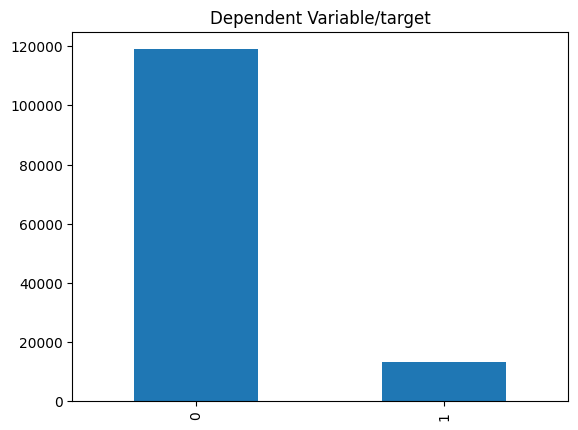

<Figure size 800x800 with 0 Axes>

In [6]:
# Exploratory plot for the dependent/taget variable.

df_pre.target.value_counts().plot(kind='bar', title='Dependent Variable/target')

plt.style.use('bmh')
plt.figure(figsize=(8, 8))

plt.show()

Data has inbalance for the dependant/target varabile. (boolean for the account status where 1 = churn, and 0 = active). Will need to address in the final dataset preparation.

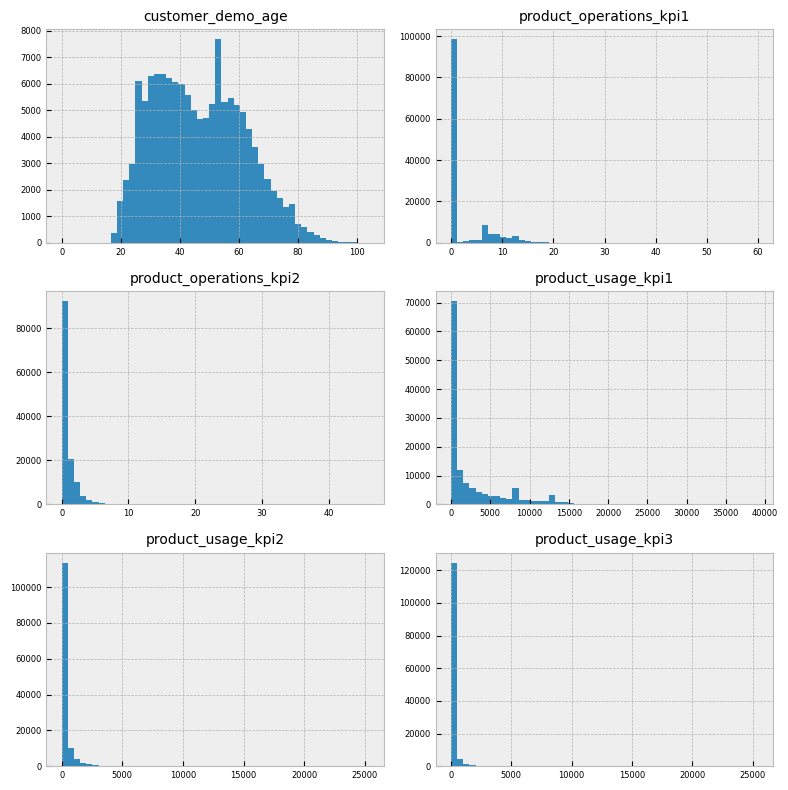

In [7]:
# Exploratory plots for features with continuous values

feature_lst = ['customer_demo_age','product_operations_kpi1','product_operations_kpi2','product_usage_kpi1','product_usage_kpi2','product_usage_kpi3']

df_eda = df_pre[feature_lst]

# Create histograms for each feature in the dataframe
axes = df_eda.hist(bins=50, figsize=(8, 8))

# Iterate through axes and set font sizes
for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


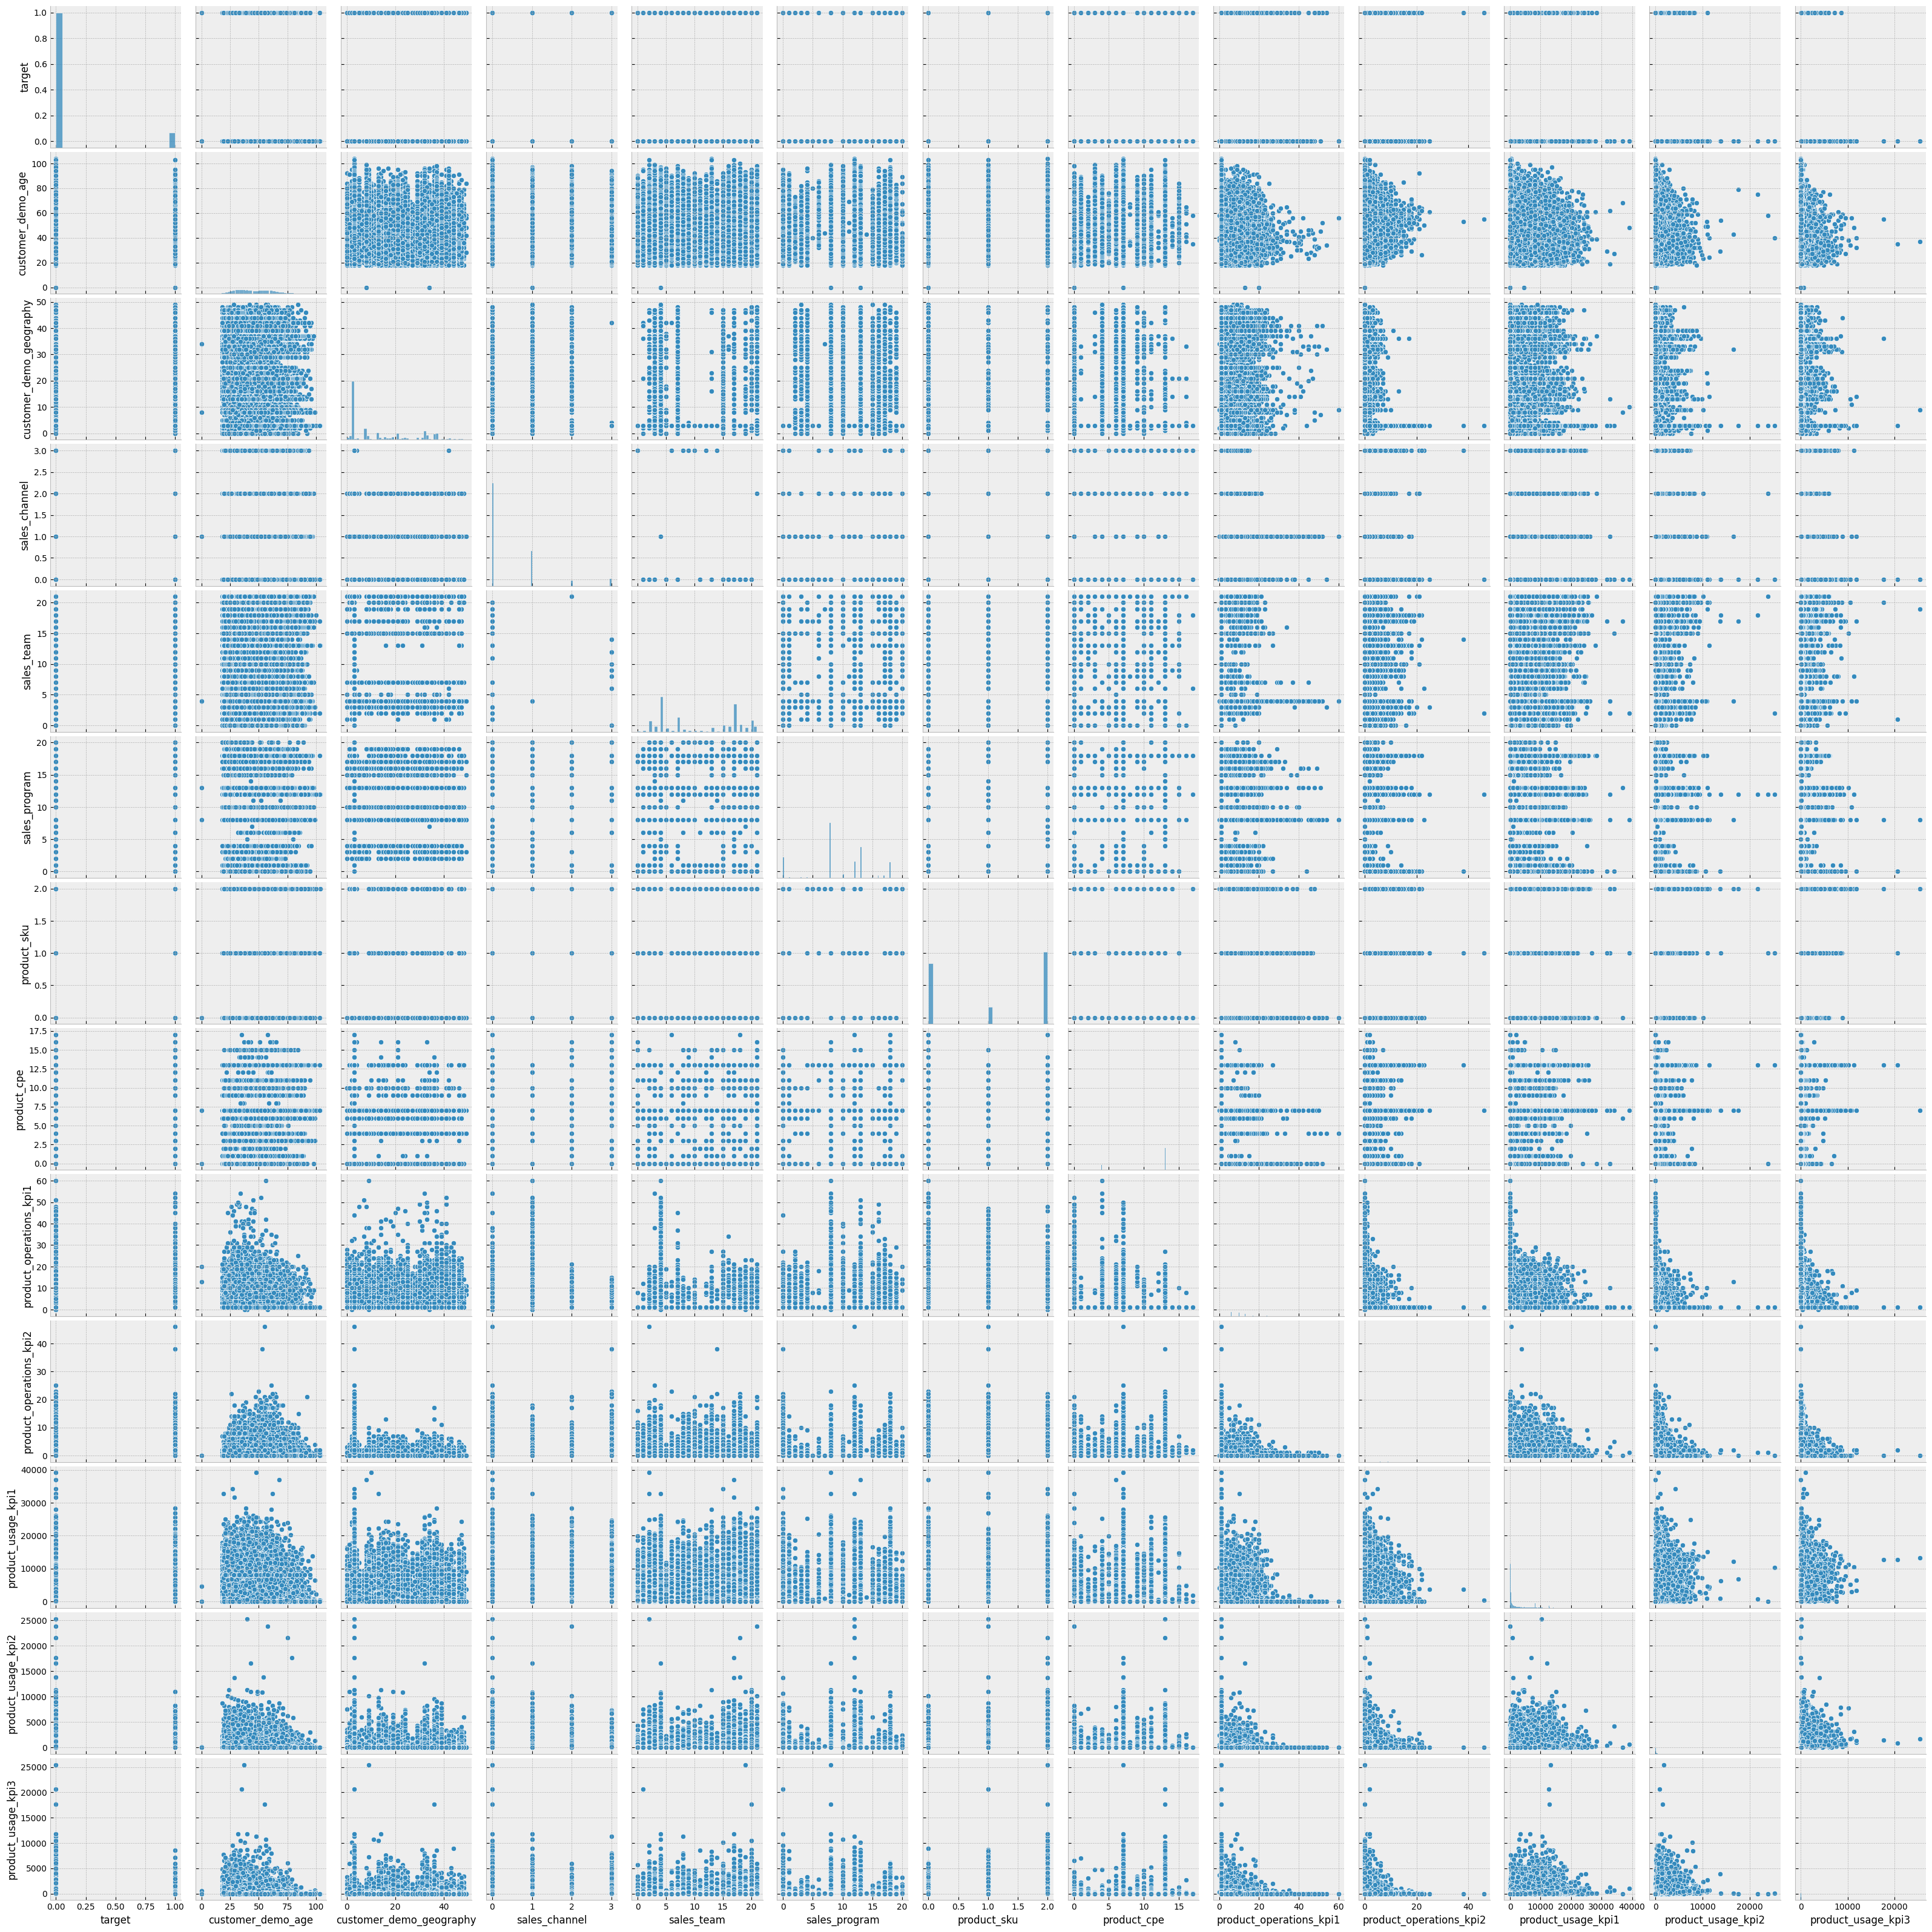

In [8]:
# Pair plots
sns.pairplot(df_pre)

plt.show()

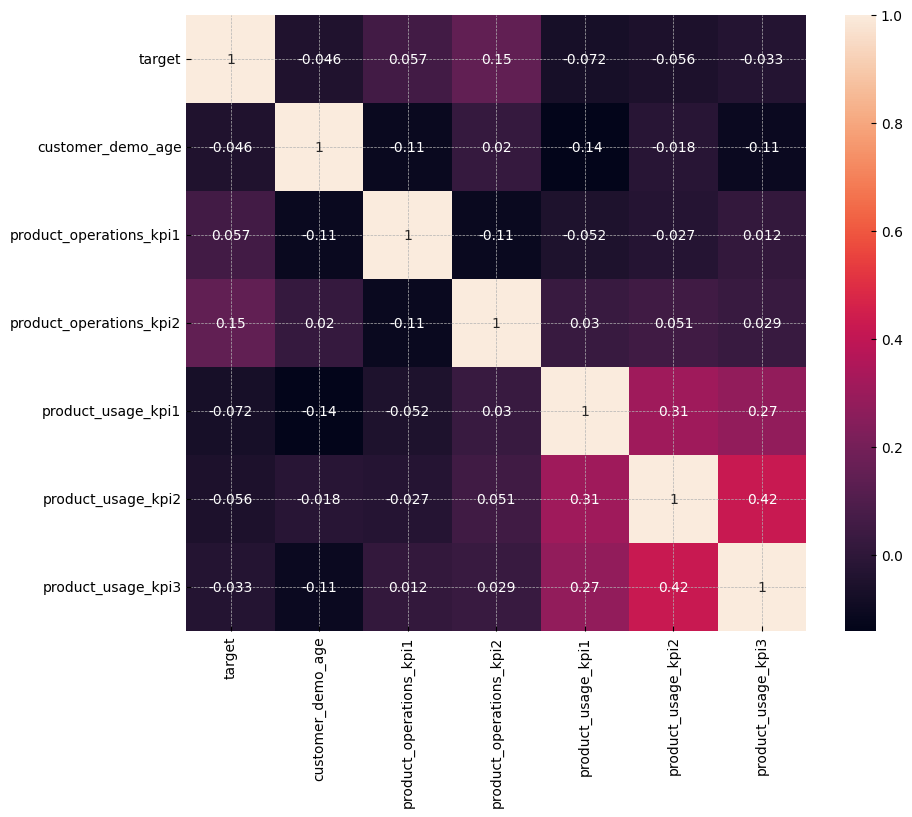

In [9]:
# Collinearity: Pearson

df_num = df_pre.select_dtypes(include = ['float64', 'int64'])

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

corrMatrix = df_num.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [10]:
# Collinearity: VIF

df_num = df_pre.select_dtypes(include = ['float64', 'int64'])

# Calculate VIF for each numeric feature
vif = pd.DataFrame()
vif["Feature"] = df_num.columns
vif["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

# Print the VIF values to identify multicollinearity among numeric features
print("VIF Values for Numeric Features:")
print(vif)

VIF Values for Numeric Features:
                   Feature       VIF
0                   target  1.136799
1        customer_demo_age  1.996923
2  product_operations_kpi1  1.462124
3  product_operations_kpi2  1.245560
4       product_usage_kpi1  1.564753
5       product_usage_kpi2  1.536760
6       product_usage_kpi3  1.363491


Features appear to be largely independent as shown by Pearson and VIF.

##Prepare Dataset

In [11]:
# Normalize continuous features
columns_to_norm = ['product_usage_kpi1','product_usage_kpi2', 'product_usage_kpi3','product_operations_kpi1','product_operations_kpi2']

for column in columns_to_norm:
  df_pre[column] = df_pre[column] / df_pre[column].abs().max()

# Bin age into generations
# Assumption is that trends fall along generations more than specific ages
# https://www.beresfordresearch.com/age-range-by-generation/

df_pre['customer_demo_age_gen'] = df_pre['customer_demo_age'].apply(lambda age:
    'gen_z' if age >= 12 and age <= 27 else
    'millennial' if age >= 28 and age <= 43 else
    'gen_x' if age >= 44 and age <= 59 else
    'boomers' if age >= 60 and age <= 78 else
    'post_war' if age >= 79 and age <= 96 else
    'invalid' if age < 18 and age > 99 else
    'other'
)

# Drop age
df_pre.drop('customer_demo_age', axis=1, inplace=True)


# Flatten categorical features
categorical_features = ['product_sku','sales_channel','sales_team','product_cpe','sales_program','customer_demo_age_gen','customer_demo_geography']

# Perform one-hot encoding (flattening) of the specified columns
df_pre = pd.get_dummies(df_pre, columns=categorical_features)

# Convert boolean values to integers (1 and 0)
df_pre = df_pre.astype(int)

###Feature Reduction

In [12]:
# Initial feature counts

unique_column_names = set(df_pre.columns)
column_count = len(unique_column_names)
print(f"Total Features: {column_count}")

Total Features: 129


In [13]:
# Perform ANOVA tests for each feature and reduce features

from scipy.stats import f_oneway

alpha = 0.05
anova_results = []
features_to_drop = []
target_variable = 'target'

for feature_column in df_pre.columns:
    if feature_column != target_variable:
        # Group data by target variable and perform ANOVA
        grouped_data = [group[1] for group in df_pre.groupby(target_variable)[feature_column]]
        f_statistic, p_value = f_oneway(*grouped_data)
        if p_value >= alpha:
            significance = 'Not Significant'
            features_to_drop.append(feature_column)
        else:
            significance = 'Significant'

        # Store the results
        anova_results.append([feature_column, f_statistic, p_value, significance])

# Drop non-significant features
df_pre.drop(columns=features_to_drop, inplace=True)

In [14]:
# Additional feature reduction with Recursive Feature Elimination (RFE)

from sklearn.tree import DecisionTreeClassifier

# Extract the target variable and create X and y
y = df_pre['target']
X = df_pre.drop(columns=['target'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Specify the number of features to select (you can adjust this)
num_features_to_select = 12

# Create the RFE model
rfe = RFE(estimator=clf, n_features_to_select=num_features_to_select)

# Fit the RFE model to the training data
rfe.fit(X_train, y_train)

# Get the selected feature names
selected_feature_names = X.columns[rfe.support_]

# Print the names of the selected features
print("Selected feature names:", selected_feature_names.tolist())

# Filter both the training and test sets using the selected features
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Train and evaluate your model using the selected features and the test data
clf.fit(X_train_selected, y_train)
accuracy = clf.score(X_test_selected, y_test)
print(f"Accuracy on test data with selected features: {accuracy:.2f}")

# Create a final DataFrame including the selected features and the target variable
df_final = df_pre[selected_feature_names].copy()
df_final['target'] = y


Selected feature names: ['product_sku_1', 'product_sku_2', 'sales_channel_0', 'sales_team_3', 'sales_team_17', 'product_cpe_6', 'product_cpe_7', 'sales_program_8', 'sales_program_18', 'customer_demo_age_gen_boomers', 'customer_demo_geography_3', 'customer_demo_geography_8']
Accuracy on test data with selected features: 0.90


In [15]:
# Feature count after reduction

unique_column_names = set(df_final.columns)
column_count = len(unique_column_names)
print(f"Total Features: {column_count}")

Total Features: 13


###Class Imbalance

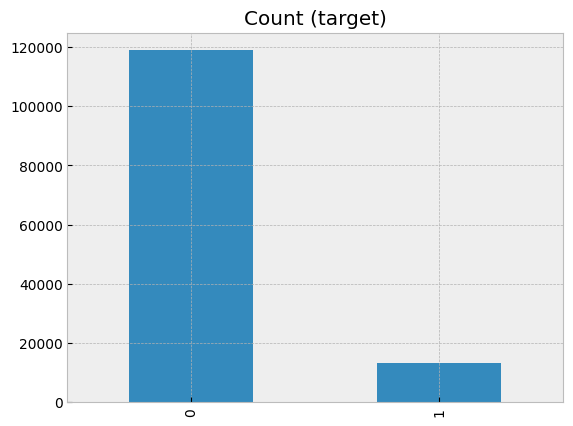

<Figure size 1000x800 with 0 Axes>

In [16]:
# Address class imbalance of the target

df_final.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

Random over-sampling:
0    118901
1    118901
Name: target, dtype: int64


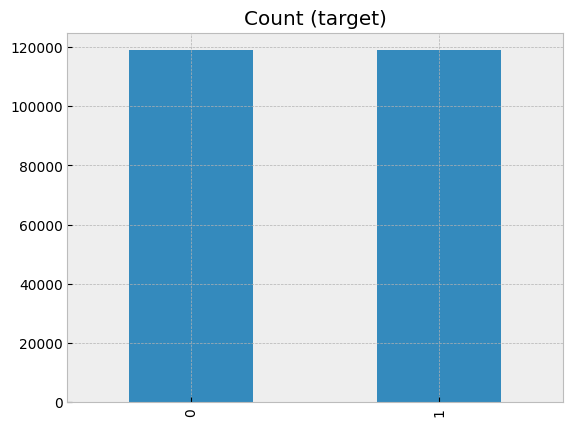

<Figure size 1000x800 with 0 Axes>

In [17]:
# Oversample the minority class using "random over sampling"
# This linear approach supports cleaner interpretation of
# feature importance.

count_class_0, count_class_1 = df_final.target.value_counts()

# Divide by class
df_class_0 = df_final[df_final['target'] == 0] #majority class
df_class_1 = df_final[df_final['target'] == 1] #minority class

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.target.value_counts())

df_over.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

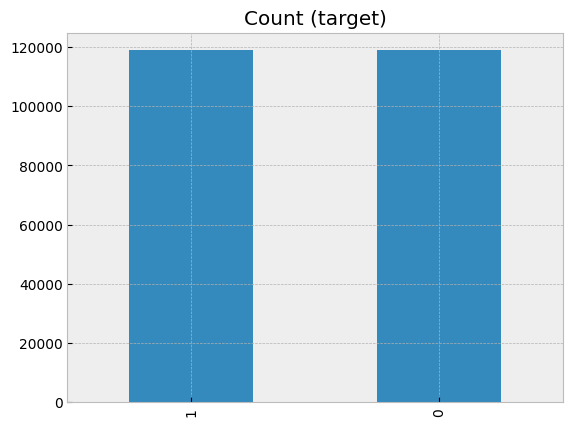

In [18]:
# Shuffle the array before train/test split

df_over = shuffle(df_over,random_state=0)
df_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [19]:
# Train/test splits

X, y = df_over, df_over.pop("target")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=888)

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190241 entries, 121937 to 1588
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   product_sku_1                  190241 non-null  int64
 1   product_sku_2                  190241 non-null  int64
 2   sales_channel_0                190241 non-null  int64
 3   sales_team_3                   190241 non-null  int64
 4   sales_team_17                  190241 non-null  int64
 5   product_cpe_6                  190241 non-null  int64
 6   product_cpe_7                  190241 non-null  int64
 7   sales_program_8                190241 non-null  int64
 8   sales_program_18               190241 non-null  int64
 9   customer_demo_age_gen_boomers  190241 non-null  int64
 10  customer_demo_geography_3      190241 non-null  int64
 11  customer_demo_geography_8      190241 non-null  int64
dtypes: int64(12)
memory usage: 18.9 MB


##Model Comparison


###Logistic Regression

In [21]:
# Create model

from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()

In [22]:
# Fit and score the model

model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.67      0.72     23844
           1       0.71      0.80      0.75     23717

    accuracy                           0.73     47561
   macro avg       0.74      0.73      0.73     47561
weighted avg       0.74      0.73      0.73     47561



C=0.0001, train: 0.737, test: 0.733
C=0.0003, train: 0.738, test: 0.734
C=0.0007, train: 0.739, test: 0.735
C=0.0018, train: 0.738, test: 0.735
C=0.0048, train: 0.738, test: 0.735
C=0.0127, train: 0.738, test: 0.735
C=0.0336, train: 0.738, test: 0.734
C=0.0886, train: 0.738, test: 0.734
C=0.2336, train: 0.738, test: 0.734
C=0.6158, train: 0.738, test: 0.734
C=1.6238, train: 0.738, test: 0.734
C=4.2813, train: 0.738, test: 0.734
C=11.2884, train: 0.738, test: 0.734
C=29.7635, train: 0.738, test: 0.734
C=78.4760, train: 0.738, test: 0.734
C=206.9138, train: 0.738, test: 0.734
C=545.5595, train: 0.738, test: 0.734
C=1438.4499, train: 0.738, test: 0.734
C=3792.6902, train: 0.738, test: 0.734
C=10000.0000, train: 0.738, test: 0.734


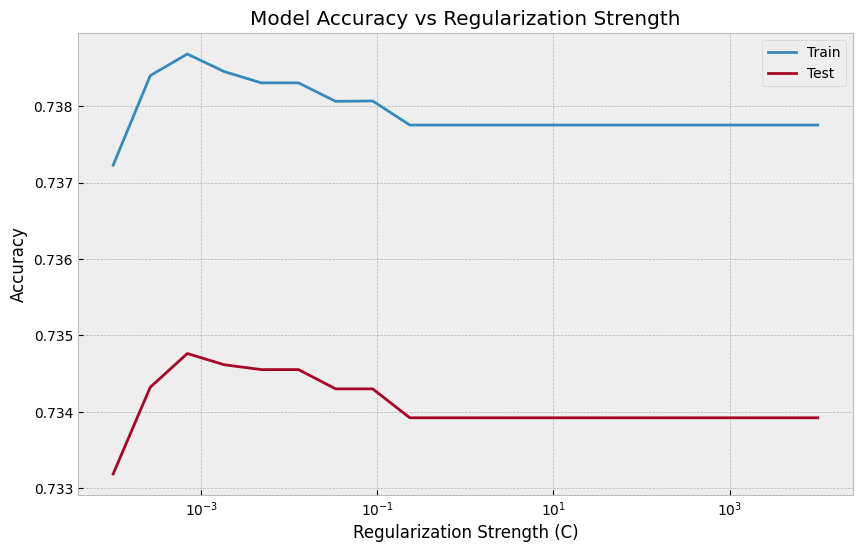

In [23]:
# Look for overfitting

# Define the regularization strengths to evaluate
C_values = np.logspace(-4, 4, 20)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each regularization strength
for C in C_values:

    # Configure the model
    model_lr = LogisticRegression(C=C, max_iter=1000)

    # Fit model on the training dataset
    model_lr.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_lr.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_lr.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('C=%.4f, train: %.3f, test: %.3f' % (C, train_acc, test_acc))

# Plot of train and test scores vs regularization strength
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_scores, label='Train')
plt.semilogx(C_values, test_scores, label='Test')
plt.title('Model Accuracy vs Regularization Strength')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))  # Set y-axis formatter
plt.legend()
plt.show()

In [24]:
# Get model parameters

for parameter in model_lr.get_params():
    print(parameter)

C
class_weight
dual
fit_intercept
intercept_scaling
l1_ratio
max_iter
multi_class
n_jobs
penalty
random_state
solver
tol
verbose
warm_start


In [25]:
# Define hyperparameter dictionary

param_dict = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize Logistic Regression
log_reg = LogisticRegression()

# Set up GridSearchCV
grid = GridSearchCV(estimator=log_reg,
                    param_grid=param_dict,
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

# Fit GridSearchCV to the training data
grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=1)

In [26]:
# Extact the best preforming hyper-parameter values

grid.best_params_

{'C': 0.0018329807108324356, 'penalty': 'l1', 'solver': 'liblinear'}

In [27]:
# Update model

model_lr_u=LogisticRegression(C = 0.0018,
                                   penalty ='l1',
                                   solver = 'liblinear')

In [28]:
#Fit and re-score the model

model_lr_u.fit(X_train, y_train)


y_pred = model_lr_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     23844
           1       0.72      0.78      0.75     23717

    accuracy                           0.74     47561
   macro avg       0.74      0.74      0.74     47561
weighted avg       0.74      0.74      0.74     47561



Churn: ROC AUC=0.500
Logistic: ROC AUC=0.787


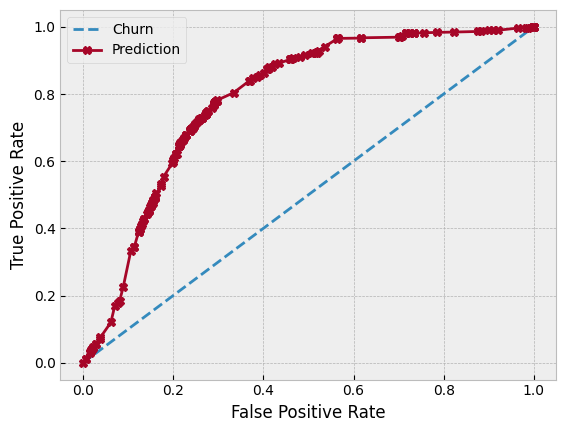

In [29]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_lr_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [30]:
# Get the feature weights (coefficients)
weights_lr = model_lr.coef_[0]

# Create a DataFrame for easy viewing
importance_lr = pd.DataFrame({'Feature': X_train.columns, 'Weight': weights_lr})
print(importance_lr)

                          Feature    Weight
0                   product_sku_1 -0.663623
1                   product_sku_2 -3.029530
2                 sales_channel_0 -0.288969
3                    sales_team_3  0.382555
4                   sales_team_17 -0.435922
5                   product_cpe_6 -1.166365
6                   product_cpe_7 -0.132561
7                 sales_program_8 -0.088500
8                sales_program_18 -0.319417
9   customer_demo_age_gen_boomers -0.209220
10      customer_demo_geography_3  0.359061
11      customer_demo_geography_8 -0.243636


###Decision Tree Classification

In [31]:
# Create model

from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier()

In [32]:
# Fit and score the model

model_dt.fit(X_train, y_train)

y_pred = model_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73     23844
           1       0.71      0.83      0.77     23717

    accuracy                           0.75     47561
   macro avg       0.75      0.75      0.75     47561
weighted avg       0.75      0.75      0.75     47561



>1, train: 0.719, test: 0.715
>2, train: 0.737, test: 0.734
>3, train: 0.737, test: 0.734
>4, train: 0.740, test: 0.738
>5, train: 0.743, test: 0.740
>6, train: 0.749, test: 0.746
>7, train: 0.749, test: 0.748
>8, train: 0.750, test: 0.747
>9, train: 0.750, test: 0.747
>10, train: 0.750, test: 0.747


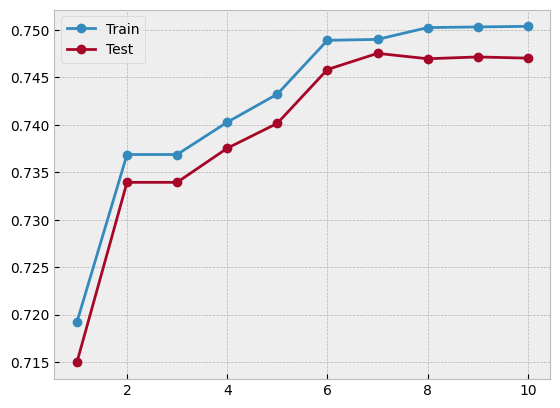

In [33]:
# Look for overfitting

# Define the tree depths to evaluate
values = [i for i in range(1, 11)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_dt = DecisionTreeClassifier(max_depth=i, random_state=42)

    # fit model on the training dataset
  model_dt.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_dt.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_dt.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [34]:
# Get model parameters

model_dt = DecisionTreeClassifier()
for parameter in model_dt.get_params():
    print(parameter)

ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
random_state
splitter


In [35]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

param_dict = {'criterion' :['gini', 'entropy'],
            'max_depth' :range(1,11),
            'min_samples_split': [20, 50],
            'min_samples_leaf': [20, 50],
            'ccp_alpha': [0.0001, 0.001]
              }

tree_class = DecisionTreeClassifier()


grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 5,
        verbose= 1,
        n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 11),
                         'min_samples_leaf': [20, 50],
                         'min_samples_split': [20, 50]},
             verbose=1)

In [36]:
# Extact the best preforming hyper-parameter values

grid.best_params_

{'ccp_alpha': 0.0001,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20}

In [37]:
# Update model

model_dt_u=DecisionTreeClassifier(ccp_alpha = 0.0001,
                                   criterion ='entropy',
                                   max_depth = 8,
                                   min_samples_leaf = 20,
                                   min_samples_split = 20
                                   )

In [38]:
#Fit and re-score the model

model_dt_u.fit(X_train, y_train)


y_pred = model_dt_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.67      0.72     23844
           1       0.71      0.82      0.76     23717

    accuracy                           0.74     47561
   macro avg       0.75      0.74      0.74     47561
weighted avg       0.75      0.74      0.74     47561



>1, train: 0.719, test: 0.715
>2, train: 0.737, test: 0.734
>3, train: 0.737, test: 0.734
>4, train: 0.740, test: 0.738
>5, train: 0.743, test: 0.740
>6, train: 0.749, test: 0.746
>7, train: 0.749, test: 0.748
>8, train: 0.750, test: 0.747


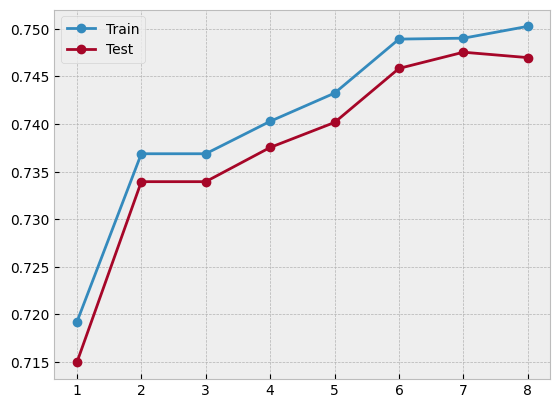

In [39]:
# Look again for overfitting

# Define the tree depths to evaluate
values = [i for i in range(1, 8)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_dt_u = DecisionTreeClassifier(max_depth=i, random_state=888)

    # fit model on the training dataset
  model_dt_u.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_dt_u.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_dt_u.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

Churn: ROC AUC=0.500
Logistic: ROC AUC=0.826


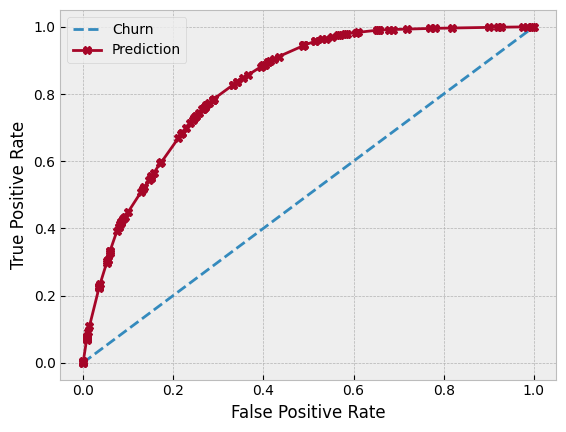

In [40]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_dt_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [41]:
# Get the feature importance

importance_dt = model_dt_u.feature_importances_

# Create a DataFrame for easy viewing
importance_dt = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_dt})
print(importance_dt)

                          Feature  Importance
0                   product_sku_1    0.007120
1                   product_sku_2    0.665606
2                 sales_channel_0    0.024226
3                    sales_team_3    0.007753
4                   sales_team_17    0.030012
5                   product_cpe_6    0.125880
6                   product_cpe_7    0.002581
7                 sales_program_8    0.005068
8                sales_program_18    0.003637
9   customer_demo_age_gen_boomers    0.005954
10      customer_demo_geography_3    0.107648
11      customer_demo_geography_8    0.014515


### Random Forrest Classifier

In [42]:
# Create model

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()

In [43]:
# Fit and score the model
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.66      0.72     23844
           1       0.71      0.83      0.77     23717

    accuracy                           0.75     47561
   macro avg       0.75      0.75      0.74     47561
weighted avg       0.75      0.75      0.74     47561



Max depth: 1, Train Accuracy: 0.719, Test Accuracy: 0.715
Max depth: 2, Train Accuracy: 0.734, Test Accuracy: 0.731
Max depth: 3, Train Accuracy: 0.735, Test Accuracy: 0.731
Max depth: 4, Train Accuracy: 0.745, Test Accuracy: 0.742
Max depth: 5, Train Accuracy: 0.747, Test Accuracy: 0.744
Max depth: 6, Train Accuracy: 0.748, Test Accuracy: 0.744
Max depth: 7, Train Accuracy: 0.749, Test Accuracy: 0.745
Max depth: 8, Train Accuracy: 0.749, Test Accuracy: 0.746
Max depth: 9, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 10, Train Accuracy: 0.750, Test Accuracy: 0.747


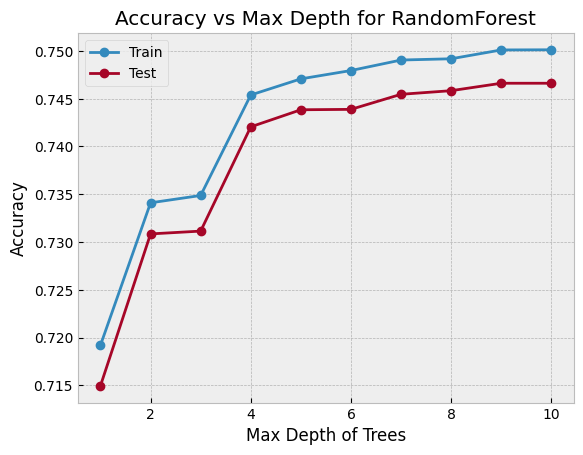

In [44]:
# Look for overfitting

# Define the tree depths to evaluate
values = range(1, 11)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model with the current max_depth
    model_rf = RandomForestClassifier(max_depth=i, random_state=42)

    # Fit the model to the training data
    model_rf.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_rf.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_rf.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for RandomForest')
plt.legend()
plt.show()


In [45]:
# Get model parameters

for parameter in model_rf.get_params():
    print(parameter)

bootstrap
ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
max_samples
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [46]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

param_dict = {
    "criterion": ["gini", "entropy"],
    "max_depth" :range(1,11),
    'min_samples_split': [20, 50],
    'min_samples_leaf': [20, 50],
    'max_features': ['auto'],
    'ccp_alpha': [0.0001, 0.001]
}

tree_class = RandomForestClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 5,
        verbose= 1,
        n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 11), 'max_features': ['auto'],
                         'min_samples_leaf': [20, 50],
                         'min_samples_split': [20, 50]},
             verbose=1)

In [47]:
# Extact the best preforming hyper-parameter values

grid.best_params_

{'ccp_alpha': 0.0001,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'min_samples_split': 50}

In [48]:
# Update model

model_rf_u = RandomForestClassifier(
                                  ccp_alpha = 0.001,
                                   criterion ='gini',
                                   max_depth = 4,
                                   max_features = 'auto',
                                   min_samples_leaf = 50,
                                   min_samples_split = 20)

In [49]:
#Fit and re-score the model

model_rf_u.fit(X_train, y_train)

y_pred = model_rf_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.63      0.71     23844
           1       0.69      0.84      0.76     23717

    accuracy                           0.73     47561
   macro avg       0.75      0.74      0.73     47561
weighted avg       0.75      0.73      0.73     47561



Max depth: 1, Train Accuracy: 0.733, Test Accuracy: 0.729
Max depth: 2, Train Accuracy: 0.734, Test Accuracy: 0.730
Max depth: 3, Train Accuracy: 0.736, Test Accuracy: 0.731
Max depth: 4, Train Accuracy: 0.748, Test Accuracy: 0.744
Max depth: 5, Train Accuracy: 0.747, Test Accuracy: 0.744
Max depth: 6, Train Accuracy: 0.748, Test Accuracy: 0.744
Max depth: 7, Train Accuracy: 0.749, Test Accuracy: 0.747
Max depth: 8, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 9, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 10, Train Accuracy: 0.750, Test Accuracy: 0.747


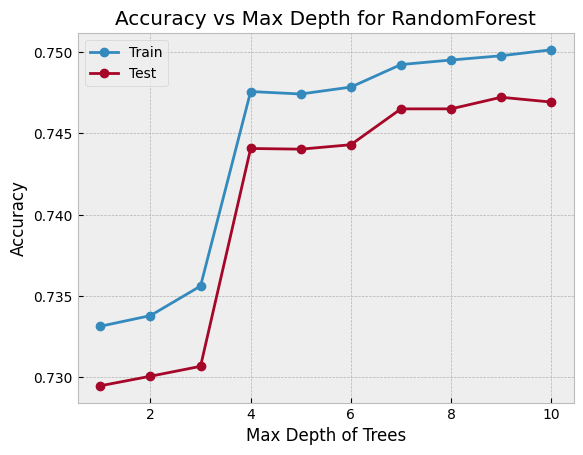

In [50]:
# Look again for overfitting

# Define the tree depths to evaluate
values = range(1, 11)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model with the current max_depth
    model_rf_u = RandomForestClassifier(max_depth=i, random_state=888)

    # Fit the model to the training data
    model_rf_u.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_rf_u.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_rf_u.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for RandomForest')
plt.legend()
plt.show()


Churn: ROC AUC=0.500
Logistic: ROC AUC=0.826


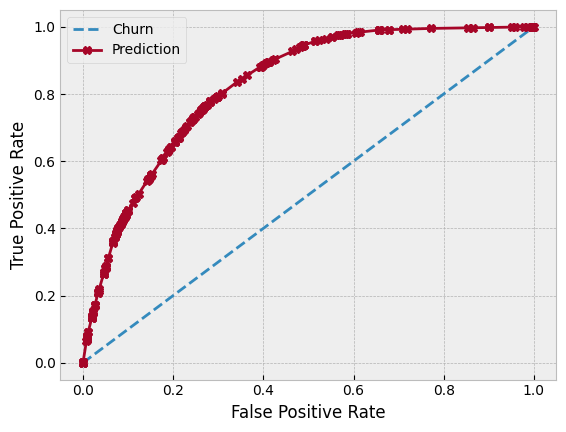

In [51]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_rf_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [52]:
# Get the feature importance
importance_rf = model_rf.feature_importances_

# Create a DataFrame for easy viewing
importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_rf})
print(importance_rf)

                          Feature  Importance
0                   product_sku_1    0.031693
1                   product_sku_2    0.587351
2                 sales_channel_0    0.052182
3                    sales_team_3    0.014905
4                   sales_team_17    0.038451
5                   product_cpe_6    0.056306
6                   product_cpe_7    0.023015
7                 sales_program_8    0.015139
8                sales_program_18    0.068725
9   customer_demo_age_gen_boomers    0.008982
10      customer_demo_geography_3    0.085585
11      customer_demo_geography_8    0.017666


##Gradient Boost


In [53]:
# Create model

from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier()

In [54]:
# Fit and score the model
model_gb.fit(X_train, y_train)

y_pred = model_gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.66      0.72     23844
           1       0.71      0.84      0.77     23717

    accuracy                           0.75     47561
   macro avg       0.75      0.75      0.74     47561
weighted avg       0.75      0.75      0.74     47561



Max depth: 1, Train Accuracy: 0.739, Test Accuracy: 0.735
Max depth: 2, Train Accuracy: 0.747, Test Accuracy: 0.744
Max depth: 3, Train Accuracy: 0.749, Test Accuracy: 0.746
Max depth: 4, Train Accuracy: 0.749, Test Accuracy: 0.745
Max depth: 5, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 6, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 7, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 8, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 9, Train Accuracy: 0.750, Test Accuracy: 0.747
Max depth: 10, Train Accuracy: 0.750, Test Accuracy: 0.747


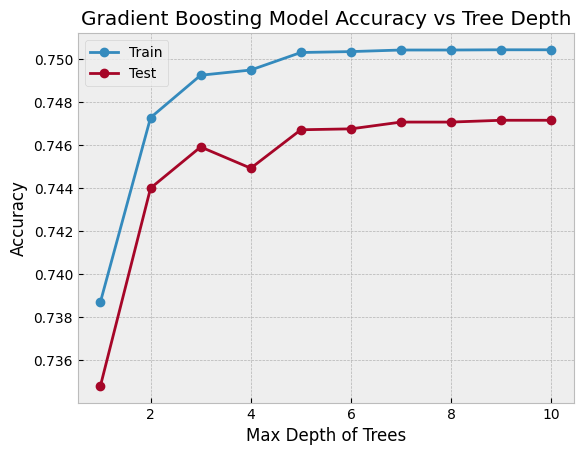

In [55]:
# Look for overfitting

# Define the tree depths to evaluate
values = range(1, 11)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Initialize the Gradient Boosting Classifier with varying max_depth
    model_gb = GradientBoostingClassifier(max_depth=i, random_state=42)

    # Fit the model to the training data
    model_gb.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_gb.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_gb.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting Model Accuracy vs Tree Depth')
plt.legend()
plt.show()


In [56]:
# Get model parameters

for parameter in model_gb.get_params():
    print(parameter)

ccp_alpha
criterion
init
learning_rate
loss
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_iter_no_change
random_state
subsample
tol
validation_fraction
verbose
warm_start


In [ ]:
# Potentially faster Grid Search for GB model

from sklearn.model_selection import RandomizedSearchCV

# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting
param_dict = {
    "criterion": ["friedman_mse", "squared_error"],
    "max_depth": range(1, 11),
    #'min_samples_split': [20, 50], # trying to reduce compute time
    #'min_samples_leaf': [20, 50],  # trying to reduce compute time
    'ccp_alpha': [0.0001, 0.001],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1]
}

tree_class = GradientBoostingClassifier()

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=tree_class,
                                   param_distributions=param_dict,
                                   n_iter=100,
                                   cv=5,
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

#param_dict = {
#    "criterion": ["friedman_mse", "squared_error"],
#    "max_depth": range(1, 11),
#    #'min_samples_split': [20, 50], # reducing compute time
#    #'min_samples_leaf': [20, 50], # reducing compute time
#    'ccp_alpha': [0.0001, 0.001],
#    'n_estimators': [100, 200, 300],
#    'learning_rate': [0.01, 0.1]
#}

#tree_class = GradientBoostingClassifier()

#grid = GridSearchCV(estimator=tree_class,
#        param_grid = param_dict,
#        cv = 5,
#        verbose= 1,
#        n_jobs = -1)

#grid.fit(X_train, y_train)

In [ ]:
# Extract the best preforming tested parameter values

grid.best_params_

In [ ]:
# Update model

model_gb_u = GradientBoostingClassifier(ccp_alpha = 0.0001,
                                   criterion ='friedman_mse',
                                   max_depth = 4,
                                   min_samples_split = 20,
                                   min_samples_leaf = 20)

In [ ]:
#Fit and re-score the model

model_gb_u.fit(X_train, y_train)

y_pred = model_gb_u.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
# Look again for overfitting

# Define the tree depths to evaluate
values = range(1, 11)

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model with the current max_depth
    model_gb_u = RandomForestClassifier(max_depth=i, random_state=888)

    # Fit the model to the training data
    model_gb_u.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_gb_u.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = model_gb_u.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('Max depth: %d, Train Accuracy: %.3f, Test Accuracy: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for RandomForest')
plt.legend()
plt.show()


In [ ]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# fit a model
model_gb_u.fit(X_train, y_train.values)

# predict probabilities
lr_probs = model_gb_u.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [ ]:
# Get the feature importance
importance_gb = model_gb.feature_importances_

# Create a DataFrame for easy viewing
importance_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_gb})
print(importance_gb)

##Feature Importance

In [ ]:
# Print Global SHAP values from the updated decision tree model

import shap as shap
from shap import TreeExplainer, summary_plot

model_dt_u.fit(X_train, y_train)

exp = TreeExplainer(model_dt)
sv = exp.shap_values(X_test)

# Initialize an empty list to store feature statistics
feature_stats = []
feature_to_drop = []

# Loop through each feature and calculate min, mean, and max SHAP values
for i in range(len(X_test.columns)):
    feature_name = X_test.columns[i]
    shap_values_feature = sv[1][:, i]
    min_val = np.min(shap_values_feature)
    mean_val = np.mean(shap_values_feature)
    max_val = np.max(shap_values_feature)
    feature_stats.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped


    # Append the statistics to the list of features to drop
    # if 1==1:#not (min_val == mean_val == max_val == 0):
    if (min_val == mean_val == max_val == 0):
        feature_to_drop.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped

# Create a DataFrames of all feature with their min, mean, max values
feature_stats_df = pd.DataFrame(feature_stats, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_stats.csv'

# Save the DataFrame to the specified path as a CSV file
feature_stats_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Create a DataFrames of dropped features
feature_to_drop_df = pd.DataFrame(feature_to_drop, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_to_drop_df.csv'

# Save the DataFrame to the specified path as a CSV file
feature_to_drop_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Plots
# Display the SHAP summary plot for all features
shap.summary_plot(sv[1], X_test, max_display=20)

# Plotting the mean SHAP values for each feature
plt.figure(figsize=(10, len(feature_stats_df) / 2))  # Adjust the figure size as needed
feature_stats_df.sort_values(by='Mean SHAP Value', ascending=True, inplace=True)
plt.barh(feature_stats_df['Feature'], feature_stats_df['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Values for Each Feature')
plt.show()

print(feature_stats_df)


In [ ]:
# Force Plot visualization: single customer (Local SHAP values)

# Calculate SHAP values for the first row of the X_test dataset
shap_values_single = exp.shap_values(X_test.iloc[120]) # Good Exxample of really bad churn

# Initialize JavaScript visualization in Google Colab (even if it might not display)
shap.initjs()

# Generate a force plot using matplotlib backend
plt.figure(figsize=(40, 10))  # You can adjust the size as needed
shap.force_plot(exp.expected_value[1], shap_values_single[1], X_test.iloc[0], feature_names=X_test.columns, matplotlib=True)
plt.show()


In [ ]:
# Filter customers based on all specified features and values

high_value_features = {
    "product_cpe_6": 1,
    "product_sku_2": 1
    #"sales_team_3": 1
    #"customer_demo_age_gen_boomers" : 1
    #"sales_program_18" : 1
                       }

filtered_customers = X_test.copy()

for feature, value in high_value_features.items():
    filtered_customers = filtered_customers[filtered_customers[feature] == value]

# DataFrame to store SHAP values
shap_values_df = pd.DataFrame()

# Iterate over filtered customers to calculate SHAP values and generate force plots
for index, row in filtered_customers.iterrows():
    # Calculate SHAP values for the current example
    shap_values_example = exp.shap_values(row)

    # Append the SHAP values to the DataFrame
    shap_row_df = pd.DataFrame([shap_values_example[1]], columns=[f'shap_{col}' for col in X_test.columns])
    shap_values_df = pd.concat([shap_values_df, shap_row_df], ignore_index=True)

    # Generate a force plot for the example
    shap.initjs()
    shap.force_plot(exp.expected_value[1], shap_values_example[1], row, matplotlib=True)
    plt.show()

# Concatenate the SHAP values DataFrame with the filtered customers DataFrame
final_df = pd.concat([filtered_customers.reset_index(drop=True), shap_values_df], axis=1)

# Export to CSV
final_df.to_csv('shap_values.csv', index=False)

##Model Interpretation and Conclusions

All models resulted in similar findings. However, Random Forrest and Gradient Boosted Classification models had compute needs that made them problematic. When a Decision Tree Classifier is property tuned, its' tendency to overfit is controlled. As it is fast and easy to extract feature importance, it is my model of choice for this exercise.

Product_sku_2 consistently showed itself to be the most powerful indicator of churn, trumping all other features. The conclusion is that this feature is the "tide that raises all ships" and one that can be implemented broadly. In my commercial implementation of these findings, it was the primary focus for mitigating churn and resulted in a > 15% reduction in measured monthly churn.

Having said that, an examination of the interaction between the complete set of features for a particular customer, including demographic, sales channel, customer premise equipment and kpis shows that product_sku_2 is only a portion of the story. It should not be conclude that product_sku_2 will nullify any/all other factors for a particular customer.

##Appendix and Notes

Selecting the appropriate measure to plot train vs test to identify potential overfitting.

###Accuracy

Pros:
<br>
Simplicity: Accuracy is straightforward to understand and interpret. It's the percentage of correctly classified instances out of all instances.
Usefulness in Balanced Datasets: In cases where classes are balanced, accuracy can be a reliable measure of model performance.
<br>
<br>
Cons:
<br>
Misleading in Imbalanced Datasets: In situations where there is a significant class imbalance, accuracy can be misleading. A model could predict the majority class for all instances and still achieve high accuracy.
No Insight into Type I/II Errors: Accuracy doesn't distinguish between the types of errors (false positives and false negatives).

###F1-Score

Pros:
<br>
Balance Between Precision and Recall: F1-score provides a balance between precision and recall. It is especially useful in cases where we need to balance false positives and false negatives.
Better for Imbalanced Datasets: It is more informative than accuracy in case of an imbalanced dataset.
<br>
<br>
Cons:
<br>
More Complex to Understand: F1-score is not as intuitive as accuracy, especially for non-technical stakeholders.
Not a Single Error Type Focus: If your specific problem requires optimizing specifically for either precision or recall (but not both), F1-score might not be the best metric.

###ROC-AUC

Pros:
<br>
Performance Across Thresholds: AUC-ROC measures the model's performance across all classification thresholds, providing a comprehensive view of its effectiveness.
Useful for Imbalanced Datasets: Like F1-score, it is more informative than accuracy for imbalanced classes.
<br>
<br>
Cons:
<br>
Can Be Overly Optimistic: In highly imbalanced datasets, ROC-AUC might present an overly optimistic view of the model’s performance.
Complexity in Interpretation: Understanding and explaining ROC curves and AUC can be more complex compared to straightforward metrics like accuracy.

Decision Tree criteria

###Gini Impurity
Pros:

Faster Computation: Gini impurity is computationally less intensive as it doesn't involve logarithmic calculations, which can be advantageous for large datasets.
Performance: It tends to work well in practice and is the default in many decision tree algorithms, like in scikit-learn's DecisionTreeClassifier.
Cons:

Less Sensitive to Changes in Class Probabilities: Gini impurity might be less sensitive to probability changes of the minority class, as it squares the probability terms.

###Entropy (Information Gain)
Pros:

Sensitivity to Class Probability Changes: Entropy is more sensitive to changes in the class probabilities of the nodes, potentially leading to more balanced trees.
Information Theoretic Model: It has a basis in information theory, providing a clear interpretation in terms of information content and uncertainty.
Cons:

Computational Intensity: Calculating entropy involves logarithmic computations, which can be more computationally intensive than Gini impurity, especially for very large datasets.
Can Lead to Overfitting: In some cases, because entropy is more sensitive to class probabilities, it can lead to models that are more complex and potentially overfitted.

Hyper parameters
###Bayesian-Optimization Library:

Pro: Offers a probabilistic model that can efficiently find the optimal parameters, especially useful when the number of experiments is limited.
Con: Might be less efficient in high-dimensional space and requires careful choice of the prior.

###Scikit-Optimize:

Pro: Integrates seamlessly with scikit-learn and offers several methods including Bayesian optimization, which is useful for optimizing expensive-to-evaluate functions.
Con: Limited to optimization tasks and might not be as scalable as some other libraries.

###GPyOpt:

Pro: Built on Gaussian Process models, it is excellent for fine-tuning where evaluations of the function are expensive.
Con: Can be slower and less practical for large-scale hyperparameter optimization due to the computational cost of Gaussian Processes.
###Hyperopt:

Pro: Uses Bayesian optimization and supports parallelization, making it efficient for large searches.
Con: Can be complex to configure and understand, especially for beginners.
###SHERPA:

Pro: Designed for hyperparameter tuning of machine learning models, supports a variety of algorithms, and is easy to use.
Con: Might not offer as wide a range of optimization algorithms compared to some other tools.
###Optuna:

Pro: A modern library with an easy-to-use interface, it offers efficient and flexible optimization with visualization features.
Con: Its flexibility might come at the cost of a steeper learning curve for advanced features.
###Ray Tune:

Pro: Highly scalable, supports a wide range of optimization algorithms, and integrates well with deep learning frameworks.
Con: Its broad functionality can make it more complex to set up and use.
###Neural Network Intelligence (NNI):

Pro: Designed for neural networks, it offers a rich set of tuning strategies and easy integration with popular deep learning frameworks.
Con: More focused on neural networks, might be less applicable for other types of models.
###MLMachine:

Pro: Provides an easy-to-use framework for machine learning workflows, including hyperparameter tuning.
Con: Less known and might lack some advanced features or optimizations found in more established libraries.
###Talos:

Pro: Specifically designed for Keras models, making it very convenient for users of this framework.
Con: Limited to Keras, which might not be suitable if you're using different machine learning frameworks.
###GridSearchCV:

Pro: Part of scikit-learn, very straightforward and easy to use for exhaustive search over specified parameter values.
Con: Computationally expensive as it evaluates all possible combinations and not efficient for large hyperparameter spaces.

Feature Importance
###LIME (Local Interpretable Model-agnostic Explanations)

LIME Pros:  Model Agnostic: Works with any machine learning model.
Local Interpretation: Provides explanations for individual predictions, offering insight into how the model behaves for single instances.
Simplicity: Generates simple, interpretable models (like linear models) that approximate the predictions locally.
Speed: Can be faster than SHAP for individual explanations because it does not require a complete background dataset to make comparisons.  

LIME Cons:
Local Scope: Explanations are local and might not reflect the model's behavior in other areas of the feature space.
Stability: Explanations can sometimes be unstable, meaning similar instances can have significantly different explanations.
Representativity: The perturbation process may generate new synthetic samples that are not representative of the actual data distribution.
Complexity: Understanding and selecting the appropriate configuration can be complex and requires a good understanding of the model and the data.  

###SHAP (SHapley Additive exPlanations)
SHAP Pros:  Solid Theoretical Foundation: Based on Shapley values from cooperative game theory, providing a fair distribution of "payout" among features.
Consistency: Guarantees that feature contributions are consistent with changes in the model output.
Global Interpretation: In addition to local explanations, SHAP values can be aggregated to provide a global view of feature importance.
Feature Interaction: SHAP can capture and show feature interactions.  

SHAP Cons:
Computationally Intensive: Can be slower than LIME, especially for models with many features or complex models like ensemble methods or deep learning.
Complex Outputs: The interpretations can sometimes be more difficult to understand due to complex interactions and many contributing factors.
High Dimensionality: SHAP's computational complexity can become problematic with high-dimensional datasets.

## Parking lot of code to revisit time allowing

In [ ]:
# Graphical analysis of trees

from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

# Train a decision tree model
model = DecisionTreeClassifier(max_depth=3)  # Limit depth for visualization
model.fit(X_train, y_train)

# Export as dot file
dot_data = export_graphviz(model, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['0', '1'],  # Assuming binary classification with classes '0' and '1'
                           filled=True, rounded=True,
                           special_characters=True,
                           proportion=False,  # Set to 'True' to show percentages instead of sample counts
                           precision=2,  # Set precision for floating point numbers
                           label='all',  # Use 'root' to show labels at the root node or 'all' to show at all nodes
                           leaves_parallel=False)  # Set to 'True' to align leaf nodes horizontally

# Create graph from dot data
graph = graphviz.Source(dot_data)

# Render and show the graph
Image(graph.pipe(format='png'))


In [ ]:
# Look for overfitting via F1-score

# Define the tree depths to evaluate
values = [i for i in range(1, 15)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model
    model_dtc = DecisionTreeClassifier(max_depth=i)

    # Fit model on the training dataset
    model_dtc.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_dtc.predict(X_train)
    train_f1 = f1_score(y_train, train_yhat, average='binary')  # Modify for binary/multiclass
    train_scores.append(train_f1)

    # Evaluate on the test dataset
    test_yhat = model_dtc.predict(X_test)
    test_f1 = f1_score(y_test, test_yhat, average='binary')  # Modify for binary/multiclass
    test_scores.append(test_f1)

    # Summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_f1, test_f1))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()
